SLICED ROUND 3 !!! 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("sliced_data.csv")

In [ ]:
df.head()

,gamename,year,month,avg,gain,peak,avg_peak_perc,month_num,yearmonth,volatile
0,Counter-Strike: Global Offensive,2021,February,741013.24,-2196.42,1123485,65.9567%,2,2021-02-01,1
1,Dota 2,2021,February,404832.13,-27839.52,651615,62.1275%,2,2021-02-01,-1
2,PLAYERUNKNOWN'S BATTLEGROUNDS,2021,February,198957.52,-2289.67,447390,44.4707%,2,2021-02-01,1
3,Apex Legends,2021,February,120982.64,49215.90,196799,61.4752%,2,2021-02-01,1
4,Rust,2021,February,117742.27,-24374.98,224276,52.4988%,2,2021-02-01,-1


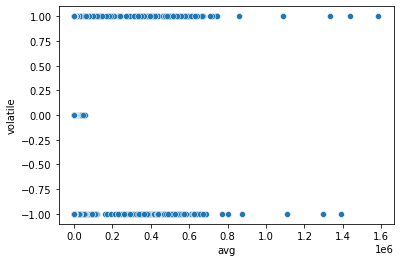

In [ ]:
sns.scatterplot(data=df, x='avg', y='volatile')

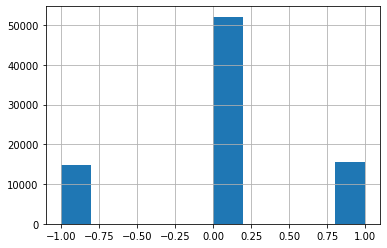

In [ ]:
df['volatile'].hist()

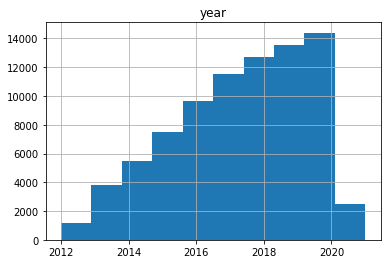

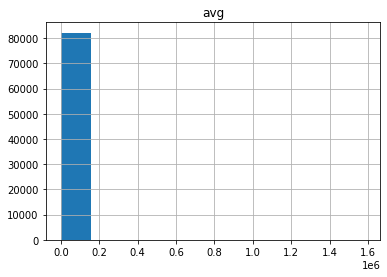

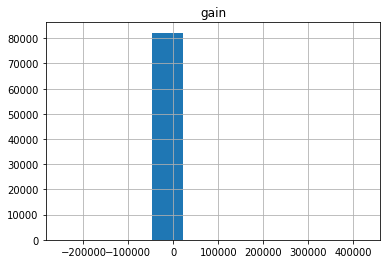

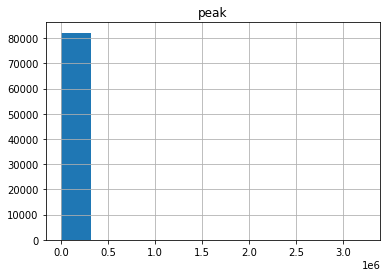

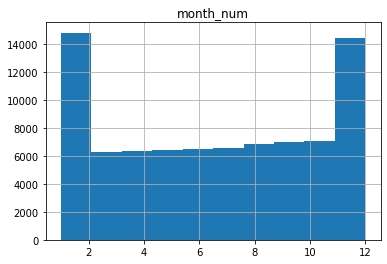

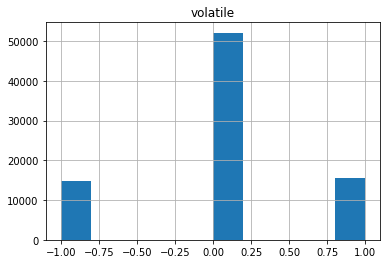

In [ ]:
for f in df.columns[df.dtypes != object]:
  df[f].hist()
  plt.title(f)
  plt.show()

Gain has the strongest linear relationship

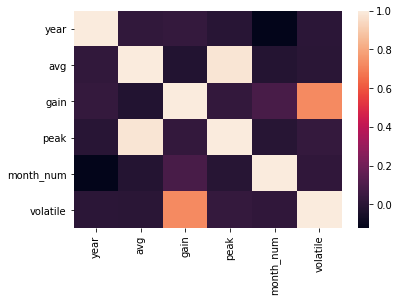

In [ ]:
sns.heatmap(df.corr('spearman'))

In [ ]:
df.head(6)

,gamename,year,month,avg,gain,peak,avg_peak_perc,month_num,yearmonth,volatile
0,Counter-Strike: Global Offensive,2021,February,741013.24,-2196.42,1123485,65.9567%,2,2021-02-01,1
1,Dota 2,2021,February,404832.13,-27839.52,651615,62.1275%,2,2021-02-01,-1
2,PLAYERUNKNOWN'S BATTLEGROUNDS,2021,February,198957.52,-2289.67,447390,44.4707%,2,2021-02-01,1
3,Apex Legends,2021,February,120982.64,49215.90,196799,61.4752%,2,2021-02-01,1
4,Rust,2021,February,117742.27,-24374.98,224276,52.4988%,2,2021-02-01,-1
5,Team Fortress 2,2021,February,101230.91,18082.74,133620,75.7603%,2,2021-02-01,1


In [ ]:
df[['yearmonth','gamename' ,'gain']].groupby('gamename').apply(lambda x: x.set_index('yearmonth')['gain'].rolling(6).mean())

gamename                      yearmonth 
100% Orange Juice             2021-02-01           NaN
                              2021-01-01           NaN
                              2020-12-01           NaN
                              2020-11-01           NaN
                              2020-10-01           NaN
                                               ...    
theHunter: Call of the Wild  2017-05-01    182.381667
                              2017-04-01    -82.865000
                              2017-03-01     33.120000
                              2017-02-01    218.440000
                              2017-01-01    133.205000
Name: gain, Length: 82373, dtype: float64

Not bad!

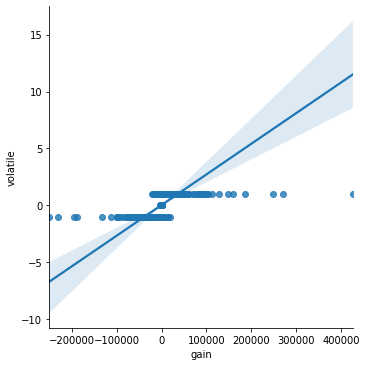

In [ ]:
sns.lmplot(x='gain', y='volatile', data=df)

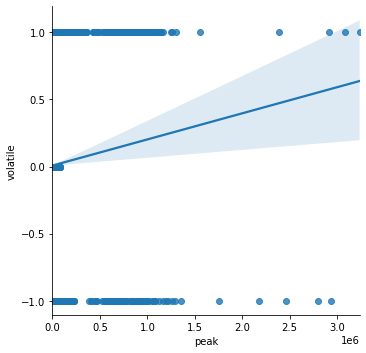

In [ ]:
sns.lmplot(x='peak', y='volatile', data=df)

In [ ]:
df.columns

Index(['gamename', 'year', 'month', 'avg', 'gain', 'peak', 'avg_peak_perc',
       'month_num', 'yearmonth', 'volatile'],
      dtype='object')

In [ ]:
df=df.drop('month',axis=1)

In [ ]:
df['avg_peak_perc'] = df['avg_peak_perc'].str[:-1].astype(float)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [ ]:
#df = df.drop('gamename', axis=1)
df['yearmonth']

prep_pipe = make_pipeline(ce.BinaryEncoder(), SimpleImputer())
pca_pipe = make_pipeline(ce.BinaryEncoder(), SimpleImputer(), PCA(n_components=2))


decomposed = pca_pipe.fit_transform(df)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
decomposed = pd.DataFrame(decomposed, columns=['pc1', 'pc2', 'cluster'])

Text(0.5, 1.0, 'PCA decomposition with cluster predictions')

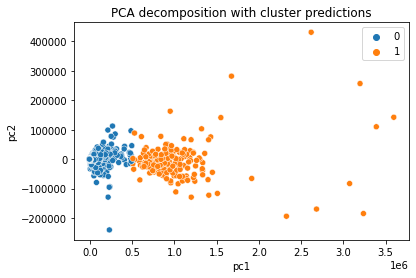

In [ ]:
sns.scatterplot(data=decomposed, x='pc1', y='pc2', hue=clusters)
plt.title('PCA decomposition with cluster predictions')

Works well without pca

In [ ]:
from sklearn.cluster import k_means
k_means_ = k_means(prep_pipe.fit_transform(df.drop('volatile', axis=1)), n_clusters=2)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
clusters = k_means_[1]

Take these clusters and use them as a feature!!

In [ ]:
df['cluster'] = clusters

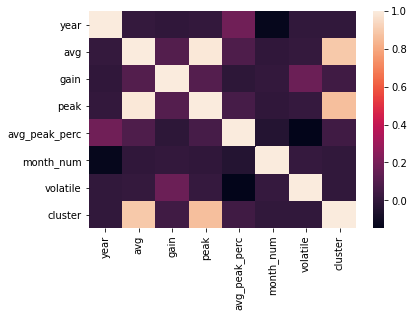

In [ ]:
sns.heatmap(df.corr())

In [ ]:
from sklearn.ensemble import RandomForestRegressor #!!!!

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
rf_reg = make_pipeline(prep_pipe, RandomForestRegressor()) 
params = {"pipeline__simpleimputer__strategy": ['mean', 'median'],
          "randomforestregressor__n_estimators": [100]
}

rf_search = RandomizedSearchCV(rf_reg, params, n_iter=1, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)

In [ ]:
rf_search.fit(X_train, y_train)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('binaryencoder',
                                                               BinaryEncoder()),
                                                              ('simpleimputer',
                                                               SimpleImputer())])),
                                             ('randomforestregressor',
                                              RandomForestRegressor())]),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'pipeline__simpleimputer__strategy': ['mean',
                                                                              'median'],
                                        'randomforestregressor__n_estimators': [100]},
                   scoring='neg_mean_absolute_error')

In [ ]:
rf_search.cv_results_

{'mean_fit_time': array([36.24445764]),
 'mean_score_time': array([0.44240435]),
 'mean_test_score': array([-0.17081388]),
 'param_pipeline__simpleimputer__strategy': masked_array(data=['mean'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_randomforestregressor__n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'pipeline__simpleimputer__strategy': 'mean',
   'randomforestregressor__n_estimators': 100}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([-0.17125713]),
 'split1_test_score': array([-0.17038716]),
 'split2_test_score': array([-0.17079735]),
 'std_fit_time': array([5.44906117]),
 'std_score_time': array([0.0498036]),
 'std_test_score': array([0.00035536])}

In [ ]:
import xgboost as xgb
param = {'max_depth':2, 'eta':1, 'objective':'multi:softmax' }
X_train, X_test, y_train, y_test = train_test_split(X, df[target])
_xgb = xgb.sklearn.XGBClassifier(objective='muti:softmax')
_xgb_p = make_pipeline(prep_pipe, _xgb)

In [ ]:
_xgb_p.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('binaryencoder', BinaryEncoder()),
                                 ('simpleimputer', SimpleImputer())])),
                ('xgbclassifier', XGBClassifier(objective='multi:softprob'))])

In [ ]:
_xgb.predict(a)

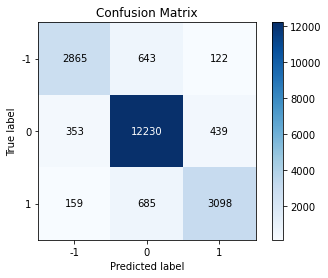

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, _xgb_p.predict(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


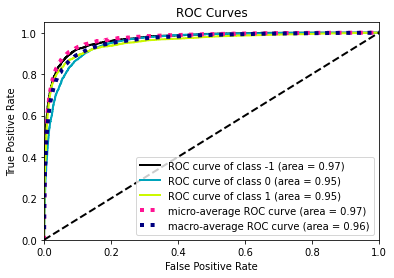

In [ ]:
skplt.metrics.plot_roc_curve(y_test, _xgb_p.predict_proba(X_test))

With more time, I'd go ahead and try 'correcting' the imbalanced dataset.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


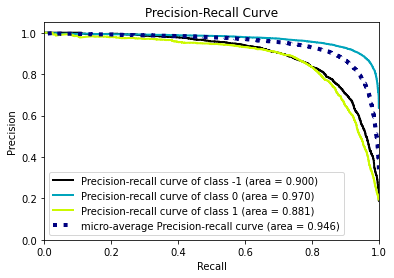

In [ ]:
skplt.metrics.plot_precision_recall_curve(y_test, _xgb_p.predict_proba(X_test))

In [ ]:
target = 'volatile'
rf_reg.fit(df.drop(target, axis=1), df[target])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('binaryencoder', BinaryEncoder()),
                                 ('simpleimputer', SimpleImputer())])),
                ('randomforestregressor', RandomForestRegressor())])

In [ ]:
import scikitplot as skplt

In [ ]:
simp_preds= rf_reg.predict(df.drop(target, axis=1))

In [ ]:
simp_preds

array([ 0.62, -1.  ,  0.72, ...,  0.98,  1.  , -0.02])

In [ ]:
import scikitplot as skplt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


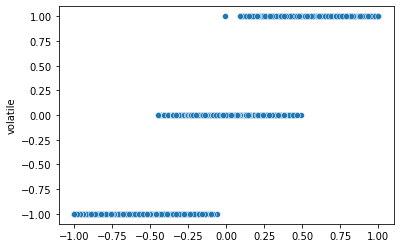

In [ ]:
sns.scatterplot(simp_preds, df[target])

In [ ]:
rf_reg.named_steps

{'pipeline': Pipeline(steps=[('binaryencoder', BinaryEncoder()),
                 ('simpleimputer', SimpleImputer())]),
 'randomforestregressor': RandomForestRegressor()}

In [ ]:
X = df.drop(target, axis=1)

Binarizer is screwing up the feature imp! 

In [ ]:
zip(X.columns, rf_reg.steps[1][1].feature_importances_)

array([2.80743861e-02, 6.18213130e-02, 7.00504038e-01, 6.70693251e-02,
       6.12398555e-02, 4.43328538e-02, 0.00000000e+00, 3.10191456e-03,
       4.64277913e-03, 4.97176761e-03, 6.14090485e-03, 6.07816748e-03,
       5.94453427e-03, 6.01580989e-03, 6.23503648e-05])

In [ ]:
prep_pipe.fit(X)
cols = prep_pipe.steps[0][1].get_feature_names()

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
feat_imp = pd.DataFrame(dict(imp = rf_reg.steps[1][1].feature_importances_, feat = cols))

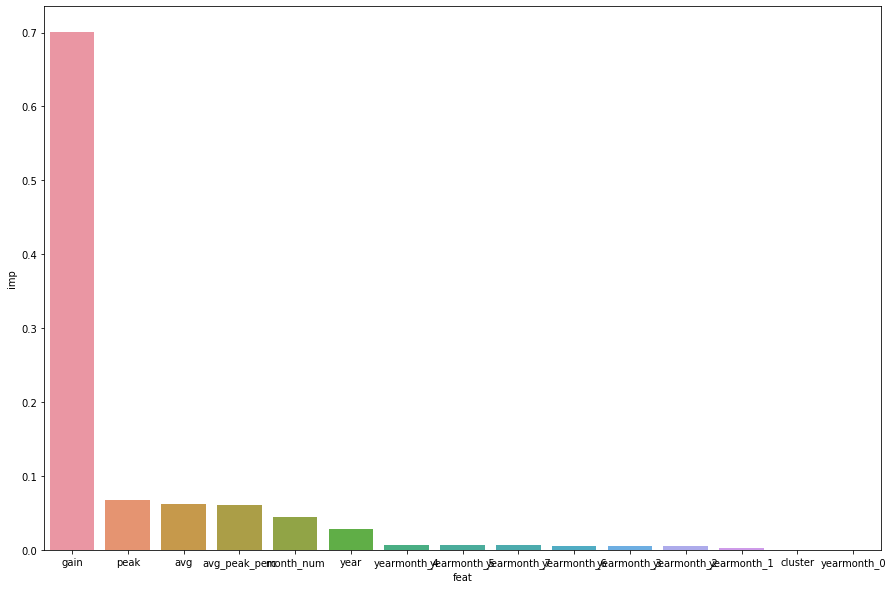

In [ ]:
fig, ax = plt.subplots(figsize=[15,10])
sns.barplot(data=feat_imp.sort_values(by='imp',ascending=False), x='feat', y='imp')

Lets try on a test set

In [ ]:
rf_reg.fit(X_train, y_train)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('binaryencoder', BinaryEncoder()),
                                 ('simpleimputer', SimpleImputer())])),
                ('randomforestregressor', RandomForestRegressor())])

In [ ]:
accuracy_score(y_true=y_test, y_pred=np.rint(rf_reg.predict(X_test)))

0.8839467806157133

In [ ]:
# precision recall curve

In [ ]:
!ls

sample_data  sliced_data.csv  sliced_holdout_data.csv


In [ ]:
hold_out = pd.read_csv('sliced_holdout_data.csv')

First submission? 

In [ ]:
hold_out.columns

Index(['year', 'avg', 'gain', 'peak', 'avg_peak_perc', 'month_num',
       'yearmonth', 'clusters'],
      dtype='object')

In [ ]:
X_train.columns

Index(['year', 'avg', 'gain', 'peak', 'avg_peak_perc', 'month_num',
       'yearmonth', 'cluster'],
      dtype='object')

In [ ]:
_xgb_p.fit(X, df['volatile'])

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('binaryencoder', BinaryEncoder()),
                                 ('simpleimputer', SimpleImputer())])),
                ('xgbclassifier', XGBClassifier(objective='multi:softprob'))])

In [ ]:
k_means_ = k_means(prep_pipe.fit_transform(hold_out), n_clusters=2)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [ ]:
pd.DataFrame({"preds":_xgb_p.predict(hold_out)}).to_csv('predictions.csv')

In [ ]:
hold_out['clusters'] = k_means_[1]

In [ ]:
hold_out = hold_out.drop(
['gamename', 'month'], axis=1
)

KeyError: ignored

In [ ]:

hold_out['avg_peak_perc'] = hold_out['avg_peak_perc'].str[:-1].astype(float)

In [ ]:
hold_out

,year,avg,gain,peak,avg_peak_perc,month_num,yearmonth,clusters
0,2021,5996.39,-286.38,10565,56.7571,2,2021-02-01,0
1,2021,6282.77,483.59,10446,60.1452,1,2021-01-01,0
2,2020,5799.18,-366.68,9478,61.1857,12,2020-12-01,0
3,2020,6165.86,229.31,10453,58.9865,11,2020-11-01,0
4,2020,5936.55,-258.72,10084,58.8710,10,2020-10-01,0
...,...,...,...,...,...,...,...,...
98,2012,25620.41,3561.48,52804,48.5198,12,2012-12-01,1
99,2012,22058.93,1780.14,46165,47.7828,11,2012-11-01,1
100,2012,20278.78,693.40,41939,48.3530,10,2012-10-01,1
101,2012,19585.39,-8320.02,38557,50.7959,9,2012-09-01,1


Post show curiosities

In [ ]:
X_train.set_index("yearmonth")

,year,avg,gain,peak,avg_peak_perc,month_num,cluster
yearmonth,,,,,,,
2017-08-01,2017,10087.14,-4786.93,18445,54.6877,8,0
2018-07-01,2018,1285.42,-507.88,2567,50.0748,7,0
2016-12-01,2016,1195.14,320.02,2672,44.7283,12,0
2018-07-01,2018,279.83,3.14,634,44.1372,7,0
2019-06-01,2019,87.84,8.81,205,42.8488,6,0
...,...,...,...,...,...,...,...
2020-07-01,2020,46.29,-8.14,99,46.7576,7,0
2020-01-01,2020,186.06,-65.97,494,37.6640,1,0
2014-01-01,2014,993.72,-756.07,2178,45.6253,1,0
